# Introduction to forward kinematics (i.e., direct geometry)

Do imports.

In [10]:
# Rigid body dynamics (pinocchio)
import pinocchio as pin

# Visualization (meshcat)
from pinocchio.visualize import MeshcatVisualizer
import meshcat_shapes

# Robot models (robot_descriptions)
from robot_descriptions.loaders.pinocchio import load_robot_description

# Math ("expm" is the matrix exponential function)
import numpy as np
from scipy.linalg import expm

# Timing
import time

# Plots
import matplotlib.pyplot as plt

# Interaction
import ipywidgets as widgets
from IPython.display import display

# Suppress the display of very small numbers
np.set_printoptions(suppress=True)

Load a robot model and show how many joints there are.

In [11]:
# Load model
robot = load_robot_description(
    'iiwa14_description',           # name of robot model
    root_joint=None,                # fixed base
)

# Show number of joints
print(f'There are {robot.nq} joints.')

There are 7 joints.


Print a list of all frames.

In [12]:
print('FRAMES\n')
for frame in robot.model.frames:
    print(f' {frame.name}')

FRAMES

 universe
 base
 iiwa_base_joint
 iiwa_link_0
 iiwa_joint_1
 iiwa_link_1
 iiwa_joint_2
 iiwa_link_2
 iiwa_joint_3
 iiwa_link_3
 iiwa_joint_4
 iiwa_link_4
 iiwa_joint_5
 iiwa_link_5
 iiwa_joint_6
 iiwa_link_6
 iiwa_joint_7
 iiwa_link_7
 iiwa_joint_ee
 iiwa_link_ee_kuka
 tool0_joint
 iiwa_link_ee


Display robot in browser.

In [22]:
# Create a visualizer
vis = MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
robot.setVisualizer(vis, init=False)
vis.initViewer(open=True)
vis.loadViewerModel()

# Choose what to display
vis.displayFrames(False)
vis.displayVisuals(True)
vis.displayCollisions(False)

# Add our own frames to the visualizer because the default frames are hard to see
frames_to_show = [
    'iiwa_link_0',
    'iiwa_link_1',
    'iiwa_link_2',
    'iiwa_link_3',
    'iiwa_link_4',
    'iiwa_link_5',
    'iiwa_link_6',
    'iiwa_link_7',
    'iiwa_link_ee_kuka',
]
for frame in frames_to_show:
    meshcat_shapes.frame(vis.viewer['frames/' + frame], opacity=1.0, axis_length=0.2)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/


Put the robot at its "neutral" configuration.

In [35]:
# Get and show the neutral configuration (most likely all zeros)
q = pin.neutral(robot.model)
print(f'{q = }')

# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

q = array([0., 0., 0., 0., 0., 0., 0.])


Create sliders that allow us to change the configuration.

In [36]:
# Callback function that receives all 7 slider values
def on_slider_change(change):
    q = np.deg2rad(np.array([slider.value for slider in sliders]))
    pin.forwardKinematics(robot.model, robot.data, q)
    pin.updateFramePlacements(robot.model, robot.data)
    vis.display(q)
    for frame in frames_to_show:
        frame_id = robot.model.getFrameId(frame)
        vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Create 7 sliders
sliders = []
for i in range(7):
    slider = widgets.FloatSlider(
        value=0,
        min=-180,
        max=180,
        step=0.1,
        description=f'Joint {i+1}:',
        continuous_update=True,  # Only update on release
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
        layout=widgets.Layout(width='600px')  # Set slider width
    )
    # Attach the same callback to each slider
    slider.observe(on_slider_change, names='value')
    sliders.append(slider)

# Display all sliders
display(widgets.VBox(sliders))

# Initialize robot
on_slider_change(None)

Define a function to do forward kinematics by product of exponentials.

In [37]:
def to_skew(w):
    om_skew = np.zeros([3,3])
    om_skew[0,1] = -w[2]
    om_skew[1,0] = w[2]
    om_skew[0,2] = w[1]
    om_skew[2,0] = -w[1]
    om_skew[1,2] = -w[0]
    om_skew[2,1] = w[0]
    return om_skew

def to_bracket(V):
    v_brack = np.zeros([4,4])
    v_brack[0:3, 0:3] = to_skew(V[0:3])
    v_brack[0:3,3] = V[3:6]
    return v_brack

def forward_kinematics_poe(theta):
    l = [0.1575, 0.2025, 0.2045, 0.2155, 0.1845, 0.2155, 0.0810, 0.0450]

    # FIXME
    a = [[0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.],
         [0., -1., 0.],
         [0., 0., 1.],
         [0., 1., 0.],
         [0., 0., 1.]]
    q = [[0., 0., l[0]],
         [0., 0., l[0]+l[1]],
         [0., 0., l[0]+l[1]+l[2]],
         [0., 0., l[0]+l[1]+l[2]+l[3]],
         [0., 0., l[0]+l[1]+l[2]+l[3]+l[4]],
         [0., 0., l[0]+l[1]+l[2]+l[3]+l[4]+l[5]],
         [0., 0., l[0]+l[1]+l[2]+l[3]+l[4]+l[5]+l[6]]]
    M = [[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., l[0]+l[1]+l[2]+l[3]+l[4]+l[5]+l[6]+l[7]],
         [0., 0., 0., 1.]]
    
    T = M
    for a_i, q_i, theta_i in reversed(list(zip(a, q, theta))):
        S = np.concatenate((a_i, -to_skew(a_i) @ q_i))
        T = expm(to_bracket(S) * theta_i) @ T

    return T

Define a function to print a homogeneous transformation matrix, rounding very small numbers to (positive) zero, so it is easy to compare two different matrices.

In [40]:
def show_homog(T, decimals=8, tol=1e-10):
    T = T.copy()
    T[np.abs(T) < tol] = 0.
    with np.printoptions(suppress=True):
        print(T)

Compare our forward kinematic solution to the one given by pinocchio.

In [41]:
# Sample a configuration at random
q = pin.randomConfiguration(robot.model)
 
# Do forward kinematics
# - Compute the placement of all joint frames (modifies robot.data but not robot.model or q)
pin.forwardKinematics(robot.model, robot.data, q)
# - Compute the placement of all link frames (modifies robot.data but not robot.model)
pin.updateFramePlacements(robot.model, robot.data)

# Show the configuration in the visualizer
vis.display(q)
for frame in frames_to_show:
    frame_id = robot.model.getFrameId(frame)
    vis.viewer['frames/' + frame].set_transform(robot.data.oMf[frame_id].homogeneous)

# Get pose of last link (pinocchio)
T_in0_of8_pin = robot.data.oMf[robot.model.getFrameId(frames_to_show[-1])].homogeneous

# Get pose of last link (by hand)
T_in0_of8_byhand = forward_kinematics_poe(q)

# Print the two solutions
print('PINOCCHIO')
show_homog(T_in0_of8_pin)
print('')
print('OURS')
show_homog(T_in0_of8_byhand)

# Check that the two solutions are the same
assert(np.allclose(T_in0_of8_pin, T_in0_of8_byhand))

PINOCCHIO
[[-0.11200992 -0.94552332 -0.30567863  0.23060394]
 [-0.06714281 -0.29971011  0.9516647   0.47086914]
 [-0.99143614  0.12712001 -0.02991459  0.40647953]
 [ 0.          0.          0.          1.        ]]

OURS
[[-0.11200992 -0.94552332 -0.30567863  0.23060394]
 [-0.06714281 -0.29971011  0.9516647   0.47086914]
 [-0.99143614  0.12712001 -0.02991459  0.40647953]
 [ 0.          0.          0.          1.        ]]


Compare the computation time.

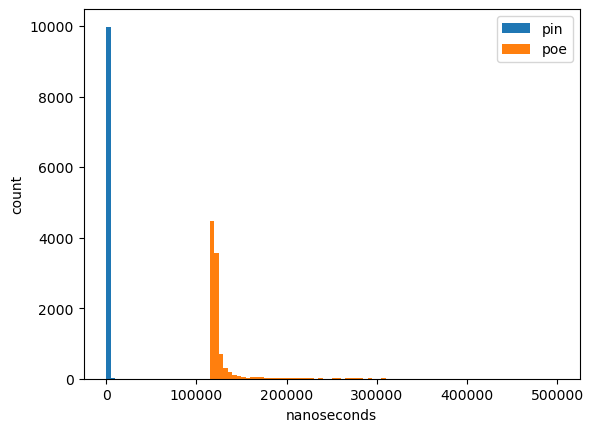

Mean computation times
 pin:      875 ns
 poe:   128616 ns


In [42]:
# Arrays in which to store computation times
t_pin = []
t_poe = []

# Number of iterations
n = 10000

# Iterate
for i in range(n):
    # Sample a configuration
    q = pin.randomConfiguration(robot.model)

    # Measure the time to do forward kinematics with pinocchio (in nanoseconds)
    start_time = time.perf_counter_ns()
    pin.framesForwardKinematics(robot.model, robot.data, q)
    end_time = time.perf_counter_ns()
    t_pin.append(end_time - start_time)

    # Measure the time to do forward kinematics by hand (in nanoseconds)
    start_time = time.perf_counter_ns()
    T = forward_kinematics_poe(q)
    end_time = time.perf_counter_ns()
    t_poe.append(end_time - start_time)

# Show histograms
plt.hist(t_pin, bins=np.linspace(0, 500000, 101), label='pin')
plt.hist(t_poe, bins=np.linspace(0, 500000, 101), label='poe')
plt.legend()
plt.xlabel('nanoseconds')
plt.ylabel('count')
plt.show()

# Print mean values
print(f'Mean computation times')
print(f' pin: {np.mean(t_pin):8.0f} ns')
print(f' poe: {np.mean(t_poe):8.0f} ns')